# <center>**Modélisation statistique avancée - Contrôle**</center>
### <center>07 Janvier 2026</center>

<center><a href="mailto:irene.balelli@inria.fr">irene.balelli@inria.fr</a></center>

## **Partie I. Questions de cours** 

On considère l'estimateur $k$-NN pour la fonction de régression $g(x)$. Dans le cours, nous avons défini l'estimateur simple comme la moyenne arithmétique des $y_i$, réalisations des $k$ $x_i$ plus proches voisins de $x$.

**Q3.** Proposez une formule générale pour un estimateur k-NN pondéré, où chaque voisin $x_i$ contribue à la prédiction en fonction d'un poids $\omega_i$ dépendant de sa distance à $x$, $d(x,x_i)$.

$\hat g_k^{KNN_p}(x)=\sum_{i\in\mathcal{N}_k}\omega_iy_i$,
où $\mathcal{N}_k$ est l'ensemble des indices des $k$-plus proches voisins de $x$.

**Q4.** Si l'on souhaite que les voisins les plus proches aient une influence plus grande que les voisins lointains, quelles propriétés doivent vérifier la fonction de poids $\omega_i$ ?

* $\omega_i\propto\left(d(x,x_i)\right)^{-1}$ - les $\omega_i$ doivent être inversement proportionnels à la distance entre $x$ et $x_i$ (ou du moins décroissants avec la distance)
* $\sum_{i\in\mathcal{N}_k}\omega_i=1$ - il faut choisir opportunemment une constante de normalisation telle que la somme des $\omega_i$ donne 1

**Bonus.** Que se passe-t-il si le point de test $x$ est exactement confondu avec l'une des observations $x_i$ de l'échantillon d'entraînement avec ce système de poids ?

Le $\omega_i$ correspondant explose (division par 0). Pour résoudre ce problème on pourrait proposer un "système de seuillage" limitant le poids maximal d'une seule observation (e.g., $\omega_i=A\cdot\frac{1}{d(x,x_i)+1}$, où $A$ assure la normalisation).

## **Partie II. Application** 

Soit $Y$ une variable aléatoire dépendante de la variable aléatoire $X$ de la façon suivante :

$$g(x):=\mathbb E[Y|X=x]=50+20\sin\left(\frac{x}{10}\right)\frac{x}{50}$$

**A1.** À l'aide de cette fonction moyenne, générer $N=200$ observations $(x_i,y_i)$ pour $x_1,\dots,x_N\in[0,100]$ (échantillonnées de manière uniforme) et en supposant pour chaque $y_i$ un bruit Gaussien centré de variance $\sigma^2=10$. Dans une même figure représentez la vraie fonction moyenne et les données.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def g(x):
    return 50+20*np.sin(x/20)*x/50

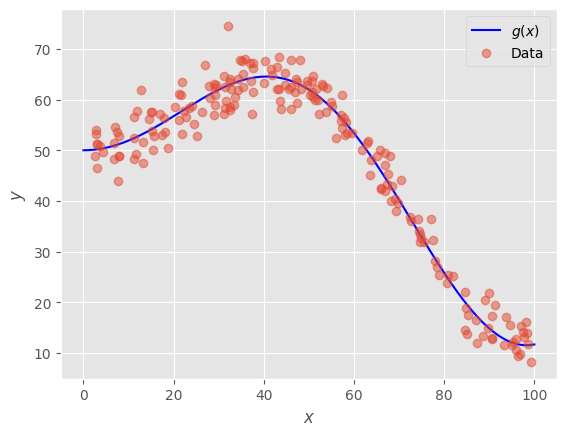

In [3]:
N = 200
X = np.random.uniform(0,100,N)
Y = g(X) + np.random.normal(scale=np.sqrt(10),size=[N])

fig, ax = plt.subplots(1, 1)

x_lin = np.linspace(0,100,1000)
ax.plot(x_lin, g(x_lin), 'b-', label='$g(x)$')
ax.plot(X, Y, 'o', alpha=0.5, label='Data')
ax.set(xlabel='$x$', ylabel='$y$')
ax.legend(loc='best')

**A2.** Soit $K(x):=\displaystyle\frac{2}{\pi}\sqrt{1-x^2}\,\mathbb{I}_{[-1,1]}(x)$.
Implémenter à l'aide d'une `classe` ou des `fonctions` l'estimateur à noyau $K$ de la fonction de régression.

In [4]:
class KRegression:

    def __init__(self,X,Y,nu=1):
        # X: independent variable (np.array)
        # Y: dependent variable (np.array)
        # nu: smoothing parameters (float). Default to 1.
        
        self.X = X
        self.Y = Y
        self.nu = nu

    def eval_kernel(self,x):
        if ((x>=-1) and (x<=1)):
            return 2*np.sqrt(1-x**2)/np.pi
        else:
            return 0

    def fit(self,x):
        # x: np.array
        hat_g = []
        for i in x:
            num = sum([self.eval_kernel((i-self.X[j])/self.nu)*self.Y[j] for j in range(len(self.X))])
            den = sum([self.eval_kernel((i-j)/self.nu) for j in self.X])
            hat_g.append(num/(den+1e-8))
        return np.array(hat_g)

**A3.** Testez plusieurs valeurs de la fenêtre $\nu$ en comparant avec la vrai fonction moyenne: lequel vous semble plus adapté ? Qu'est ce qu'il se passe si $\nu$ dévient très grand ?

In [5]:
def plot_reg(self,**kwargs):
    x_lin = np.linspace(min(self.X),max(self.X),1000)
    y_pred = self.fit(x_lin)
    return plt.plot(x_lin,y_pred, **kwargs)

KRegression.plot_reg = plot_reg

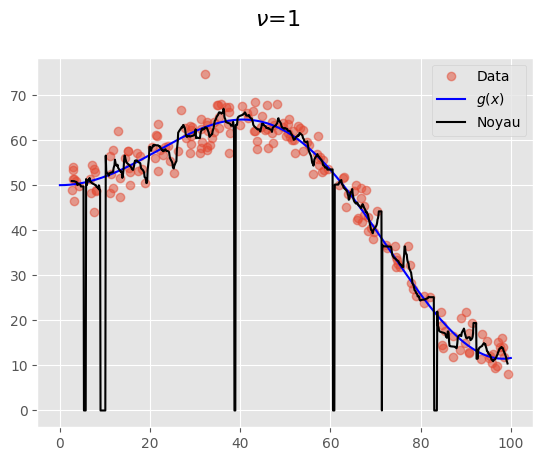

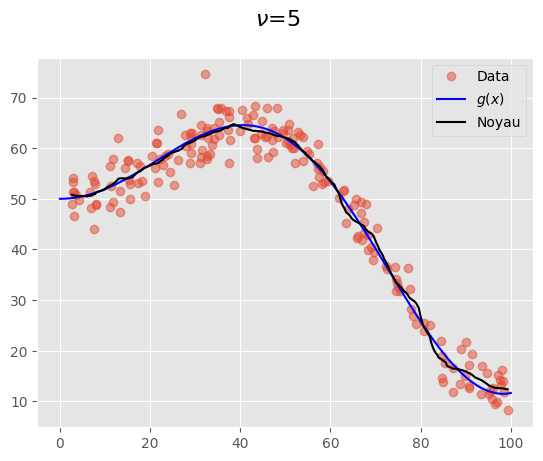

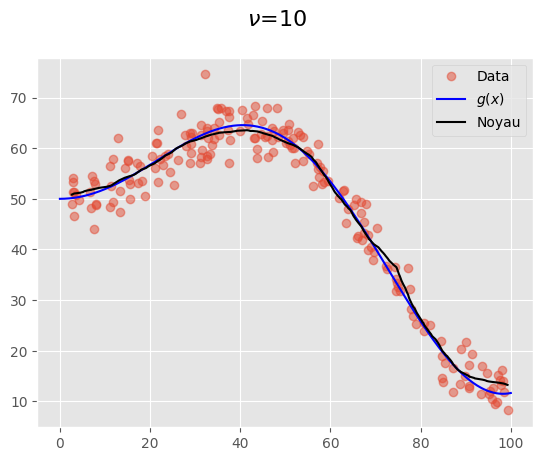

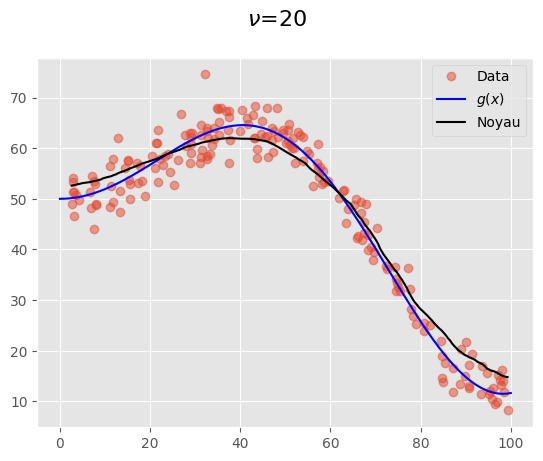

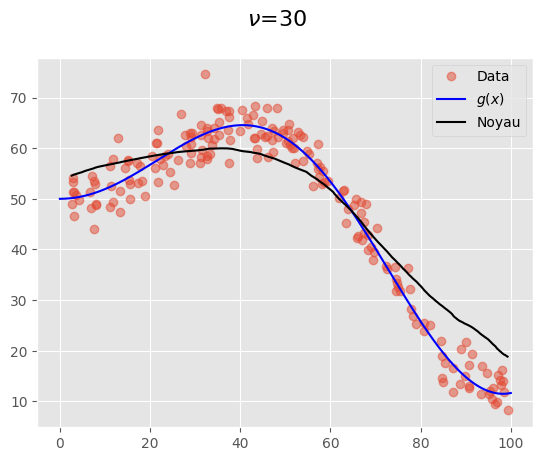

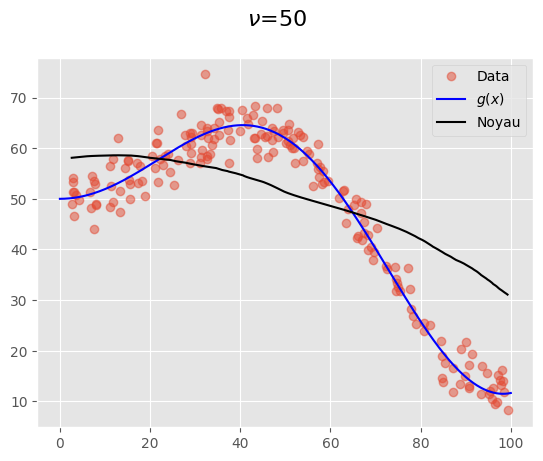

In [6]:
nus = [1,5,10,20,30,50]

for nu in nus:
    kreg = KRegression(X,Y,nu=nu)
    fig = plt.figure()
    plt.plot(X, Y, 'o', alpha=0.5, label='Data')
    plt.plot(x_lin, g(x_lin), 'b-', label='$g(x)$')
    kreg.plot_reg(color='k', label='Noyau')
    plt.legend(loc='best')
    fig.suptitle('$\\nu$={}'.format(round(nu,2)), fontsize=16)
    plt.show

Nous souhaitons proposer une méthode automatique pour estimer la valeur optimale de $\nu$. Pour cela, nous souhaitons évaluer l’erreur quadratique intégrée moyenne :
$$\textrm{MISE}(\nu)=\int_{\mathbb R}\mathbb E\left[\left(\hat g_{\nu}^K(x)-g(x)\right)^2|\mathcal D_{N}\right]dx$$

Soit $\mathcal D_{N,i}$ le dataset d'entrainement initial, d'où on a enlevé le $i$-eme couple, $(x_i,y_i)$. Soit $\hat g_{\nu,i}^K$ l'estimateur construit à partir de ce dataset incomplet. Un estimateur de $\textrm{MISE}(\nu)$, $\widehat{\textrm{MISE}}(\nu)$ peut alors être définit comme suit :

$$\widehat{\textrm{MISE}}(\nu):=\frac{1}{N}\sum_{i=1}^N(y_i-\hat g_{\nu,i}^K(x_i))^2$$

Un choix “optimal” de $\nu$ est alors obtenu par minimisation de $\widehat{\textrm{MISE}}(\nu)$:

$$\nu^{\mathrm{opt}}=\textrm{argmin}_{\nu>0}(\widehat{\textrm{MISE}}(\nu))$$

**A4.** Implementer une méthode iterative pour pouvoir déterminer $\nu^{\textrm{opt}}$ (avec une `class`ou une/plusieurs fonctions) :

* Donné : dataset $\mathcal D_N$, noyau $K$, un vecteur `V` contenant un certain nombre de valeurs possibles de $\nu$ à tester.
* Initialiser $\nu^{\textrm{opt}}=$ `V[0]` et $\widehat{\textrm{MISE}}^{\textrm{opt}}=\widehat{\textrm{MISE}}$(`V[0]`).
* Itérer sur les valeurs $\nu$ dans `V` pour minimiser $\widehat{\textrm{MISE}}$.
* Resultat : $\nu^{\textrm{opt}}, \widehat{\textrm{MISE}}^{\textrm{opt}}$

Grâce à cette méthode déterminer le $\nu$ optimale pour la régression avec le noyau $K$ donné: vous pouvez considérer l'intervalle `[0.5,15]` pour la recherche de $\nu$. Montrer graphiquement l'évolution de $\widehat{\textrm{MISE}}(\nu)$ pour tout $\nu$ testé. Représenter sur une même figure les données, la vrai fonction de régression, et son estimation avec le noyau $K$ et sa fenêtre optimale.

In [7]:
def mise(X,Y,nu):
    N=len(X)
    sum=0.0
    for i in range(N):
        X_i = np.delete(X,i)
        Y_i = np.delete(Y,i)
        y_hat = KRegression(X_i,Y_i,nu=nu).fit(np.array([X[i]]))
        sum += (Y[i]-y_hat)**2
    return sum/N

def optimal_window(X,Y,Nus=np.linspace(.1,10,100)):
    # X : data indep var (np.array)
    # Y : data dep var (np.array)
    # Nus : interval where nu research is performed (np.array)

    nu_opt = Nus[0]
    MISE_opt = mise(X,Y,nu_opt)
    MISE_list = [MISE_opt]

    for nu in Nus[1:]:
        MISE = mise(X,Y,nu)
        MISE_list.append(MISE)
        if MISE<MISE_opt:
            nu_opt = nu
            MISE_opt = MISE
    return nu_opt, MISE_opt, MISE_list

In [8]:
nu_opt, MISE_opt, MISE_list = optimal_window(X,Y,np.linspace(0.5,15,100))

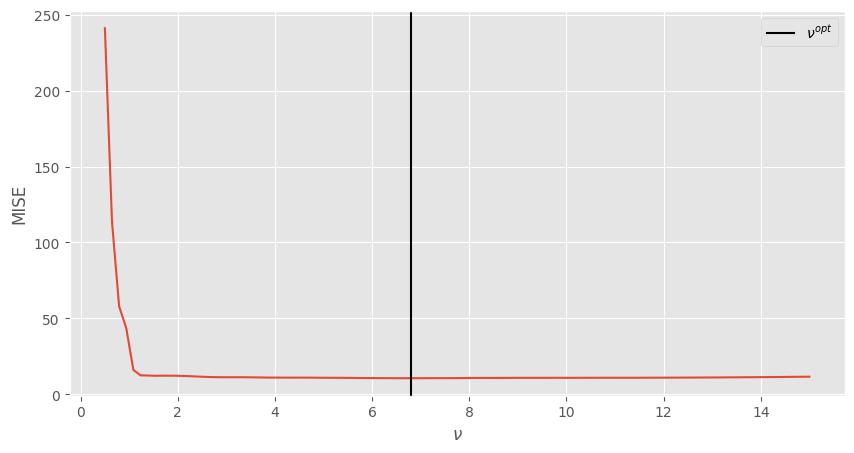

In [9]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.plot(np.linspace(0.5,15,100),MISE_list)
ax.axvline(nu_opt,color='k',label='$\\nu^{opt}$')
ax.set(xlabel='$\\nu$',ylabel='MISE')
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

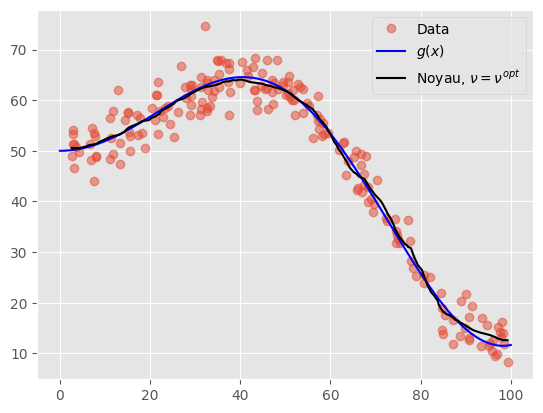

In [10]:
kreg = KRegression(X,Y,nu=nu_opt)
fig = plt.figure()
plt.plot(X, Y, 'o', alpha=0.5, label='Data')
plt.plot(x_lin, g(x_lin), 'b-', label='$g(x)$')
kreg.plot_reg(color='k', label='Noyau, $\\nu=\\nu^{opt}$')
plt.legend(loc='best')
plt.show

**A5.** Commentez la qualité de cette regression à l'aide des résiduelles, que vous représenterez sous forme d'histogramme. Est-ce que une régression linéaire serait adapté dans ce cas ?

In [11]:
def residuals(self):
    return self.Y-self.fit(self.X)

KRegression.residuals=residuals

Mean = -0.03284418687706795; Std = 3.1026195259476608


[Text(0.5, 0, 'Residuals'), Text(0, 0.5, 'Density')]

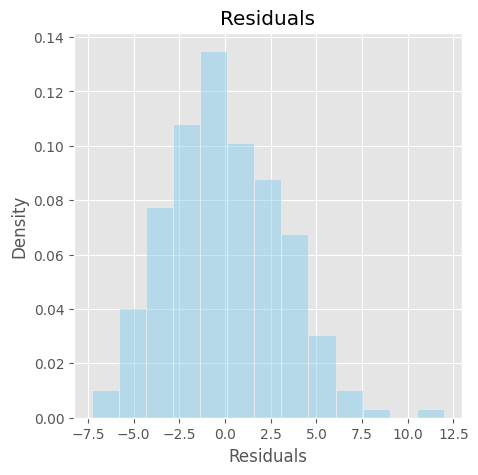

In [12]:
import seaborn as sns

Kreg = KRegression(X,Y,nu=nu_opt)
residuals = Kreg.residuals()

print(f'Mean = {np.mean(residuals)}; Std = {np.std(residuals)}')

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.title.set_text('Residuals')
ax= sns.histplot(residuals,
                     stat='density',
                     color="skyblue",
                     alpha=.5)
ax.set(xlabel='Residuals', ylabel='Density')

**Bonus.** La méthode proposé au point **A4.** pour déterminer le $\nu$ optimale pour la regression avec noyaux peut s'appliquer aussi pour déterminer le $k$ optimale pour la régression avec $k$-plus-proches-voisins. Implémentez-la et comparez cette estimation avec celle obtenue avec le noyau $K$.

In [13]:
class KNNRegression:

    def __init__(self,X,Y,k):
        # X: independent variable (np.array)
        # Y: dependent variable (np.array)
        # k: number of neighbors
        self.X = X
        self.Y = Y
        self.k = k

    def fit(self,x):
        # x: np.array
        
        import pandas as pd
        df = pd.DataFrame(np.column_stack((self.X, self.Y)), columns=['X','Y'])
        
        hat_g = []
        for i in x:
            df_temp = df.copy()
            df_temp['dist']=abs(df_temp['X']-i)
            df_temp.sort_values(by=['dist'], inplace=True)
            sum = np.sum(df_temp['Y'].values[:self.k])
            hat_g.append(sum/self.k)
        return np.array(hat_g)

    def plot_reg(self,**kwargs):
        x_lin = np.linspace(min(self.X),max(self.X),1000)
        y_pred = self.fit(x_lin)
        return plt.plot(x_lin,y_pred, **kwargs)

    def residuals(self):
        return self.Y-self.fit(self.X)
        
    def plot_true_vs_predicted(self,**kwargs):
        return plt.scatter(self.Y,self.fit(self.X), **kwargs)

In [14]:
def mise_KNN(X,Y,k):
    N=len(X)
    sum=0.0
    for i in range(N):
        X_i = np.delete(X,i)
        Y_i = np.delete(Y,i)
        y_hat = KNNRegression(X_i,Y_i,k).fit(np.array([X[i]]))
        sum += (Y[i]-y_hat)**2
    return sum/N

def optimal_k(X,Y,K):
    # X : data indep var (np.array)
    # Y : data dep var (np.array)
    # Nus : interval where nu research is performed (np.array)

    k_opt = K[0]
    MISE_opt = mise_KNN(X,Y,k_opt)
    MISE_list = [MISE_opt]

    for k in K[1:]:
        MISE = mise_KNN(X,Y,k)
        MISE_list.append(MISE)
        if MISE<MISE_opt:
            k_opt = k
            MISE_opt = MISE
    return k_opt, MISE_opt, MISE_list

In [15]:
k_opt, MISE_opt, MISE_list = optimal_k(X,Y,np.arange(1,50))

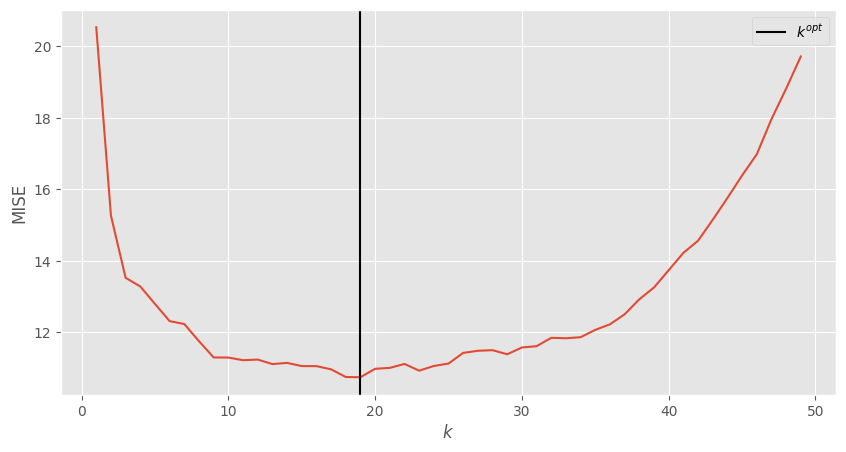

In [16]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.plot(np.arange(1,50),MISE_list)
ax.axvline(k_opt,color='k',label='$k^{opt}$')
ax.set(xlabel='$k$',ylabel='MISE')
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

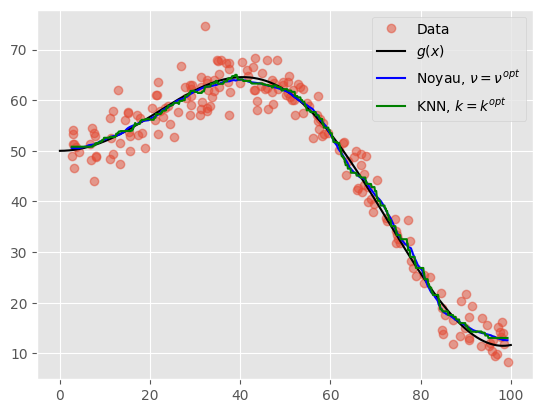

In [17]:
kreg = KRegression(X,Y,nu=nu_opt)
knnreg = KNNRegression(X,Y,k=k_opt)
fig = plt.figure()
plt.plot(X, Y, 'o', alpha=0.5, label='Data')
plt.plot(x_lin, g(x_lin), 'k-', label='$g(x)$')
kreg.plot_reg(color='b', label='Noyau, $\\nu=\\nu^{opt}$')
knnreg.plot_reg(color='g', label='KNN, $k=k^{opt}$')
plt.legend(loc='best')
plt.show

Kernel: Mean = -0.03284418687706795; Std = 3.1026195259476608
KNN: Mean = -0.07605394791666187; Std = 3.106012650439308


[Text(0.5, 0, 'Residuals'), Text(0, 0.5, 'Density')]

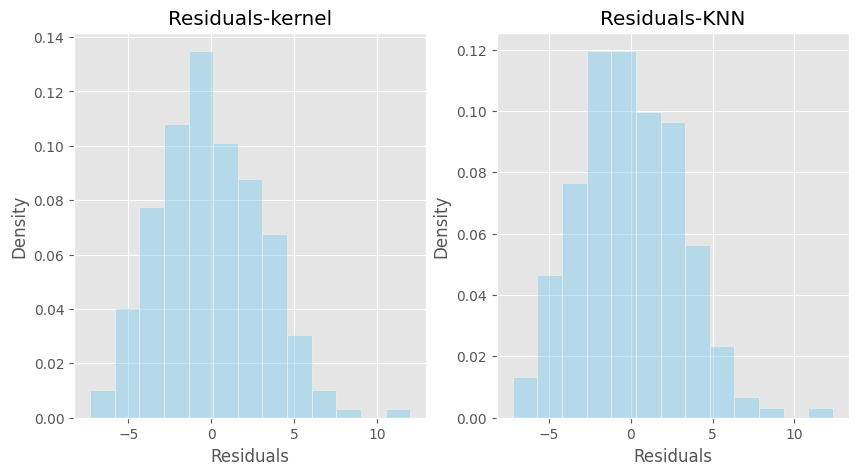

In [18]:
Kreg = KRegression(X,Y,nu=nu_opt)
residuals = Kreg.residuals()

KNNreg = KNNRegression(X,Y,k=k_opt)
KNNresiduals = KNNreg.residuals()

print(f'Kernel: Mean = {np.mean(residuals)}; Std = {np.std(residuals)}')
print(f'KNN: Mean = {np.mean(KNNresiduals)}; Std = {np.std(KNNresiduals)}')

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Residuals-kernel')
ax1= sns.histplot(residuals,
                     stat='density',
                     color="skyblue",
                     alpha=.5)
ax1.set(xlabel='Residuals', ylabel='Density')

ax2 = fig.add_subplot(122)
ax2.title.set_text('Residuals-KNN')
ax2= sns.histplot(KNNresiduals,
                     stat='density',
                     color="skyblue",
                     alpha=.5)
ax2.set(xlabel='Residuals', ylabel='Density')